In [1]:
import polars as pl
from pathlib import Path

In [2]:
data_json = Path('./data/data_earthquakes.json')

print(f"Loading data from: {data_json}")
print(f"File exists: {data_json.exists()}")

dataFrame = pl.read_json(data_json, infer_schema_length=None)
dataFrame = dataFrame.select(["mag", "time", "coordinates", "felt", "cdi", "mmi", "alert", "sig", "tsunami", "magType"])

Loading data from: data\data_earthquakes.json
File exists: True


In [3]:
print(f"Total: {len(dataFrame):,}")
print(f"Columns: {len(dataFrame.columns)}")
print(f"Date range: {dataFrame.select(pl.from_epoch('time', time_unit='ms').alias('datetime')).min().item()} to {dataFrame.select(pl.from_epoch('time', time_unit='ms').alias('datetime')).max().item()}")
with open("column_ranges.txt", "w", encoding="utf-8") as f:
    for col in dataFrame.columns:
        try:
            col_min = dataFrame[col].min()
            col_max = dataFrame[col].max()
            f.write(f"{col}: {col_min} - {col_max}\n")
        except Exception as e:
            f.write(f"{col}: Range not applicable ({e})\n")
print("Saved column ranges to column_ranges.txt")

dataFrame.head(3)

Total: 301,852
Columns: 10
Date range: 1900-01-05 19:00:00 to 2025-10-05 05:53:17.014000
Saved column ranges to column_ranges.txt


mag,time,coordinates,felt,cdi,mmi,alert,sig,tsunami,magType
f64,i64,list[f64],i64,f64,f64,str,i64,i64,str
6.2,27417501580,"[121.349, 22.78, 29.5]",null,null,5.731,null,591,0,"""mw"""
5.79,27406297890,"[143.227, 12.708, 80.0]",null,null,null,null,516,0,"""mw"""
6.55,27353783380,"[123.863, 12.081, 13.5]",null,null,6.689,null,660,0,"""mw"""


In [4]:
dataFrame.null_count()

mag,time,coordinates,felt,cdi,mmi,alert,sig,tsunami,magType
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,274030,274030,279647,293575,0,0,1


In [5]:
with open("unique_values.txt", "w", encoding="utf-8") as f:
    for column in dataFrame.columns:
        values = dataFrame[column].unique().to_list()
        f.write(f"{column}:\n")
        for v in values:
            f.write(f"  - {v}\n")
        f.write(f"Total unique values: {len(values):,}\n\n")
print("Saved to unique_values.txt")

Saved to unique_values.txt


In [6]:
dataFrame = dataFrame.with_columns([
    pl.col("coordinates").list.get(0).alias("longitude"),
    pl.col("coordinates").list.get(1).alias("latitude"), 
    pl.col("coordinates").list.get(2).alias("depth")
]).drop("coordinates")

print(f"Longitude range: {dataFrame['longitude'].min():.2f} to {dataFrame['longitude'].max():.2f}")
print(f"Latitude range: {dataFrame['latitude'].min():.2f} to {dataFrame['latitude'].max():.2f}")
print(f"Depth range: {dataFrame['depth'].min():.1f} to {dataFrame['depth'].max():.1f} km")

Longitude range: -180.00 to 180.00
Latitude range: -84.13 to 87.39
Depth range: -3.0 to 700.9 km


In [7]:
alert_mapping = {"green": 1, "yellow": 2, "orange": 3, "red": 4}

dataFrame = dataFrame.with_columns([
    pl.col("alert").map_elements(
        lambda x: alert_mapping.get(x, 0) if x is not None else 0,
        return_dtype=pl.Int32
    ).alias("alert")
])

mag_types = dataFrame.filter(pl.col("magType").is_not_null())["magType"].unique().to_list()
magtype_mapping = {mag_type: i+1 for i, mag_type in enumerate(sorted(mag_types)) if mag_type is not None}
print(f"MagType mapping: {magtype_mapping}")

dataFrame = dataFrame.with_columns([
    pl.col("magType").map_elements(
        lambda x: magtype_mapping.get(x, 0) if x is not None else 0,
        return_dtype=pl.Int32
    ).alias("magType")
])

dataFrame.head(10)

MagType mapping: {'Mb': 1, 'Md': 2, 'Ml': 3, 'fa': 4, 'lg': 5, 'm': 6, 'mB': 7, 'ma': 8, 'mb': 9, 'mb_lg': 10, 'mblg': 11, 'mc': 12, 'md': 13, 'mfa': 14, 'mh': 15, 'mint': 16, 'mj': 17, 'ml': 18, 'ml(texnet)': 19, 'mlg': 20, 'mlr': 21, 'ms': 22, 'ms_20': 23, 'mw': 24, 'mwb': 25, 'mwc': 26, 'mwp': 27, 'mwr': 28, 'mww': 29, 'uk': 30}


mag,time,felt,cdi,mmi,alert,sig,tsunami,magType,longitude,latitude,depth
f64,i64,i64,f64,f64,i32,i64,i64,i32,f64,f64,f64
6.2,27417501580,null,null,5.731,null,591,0,24,121.349,22.78,29.5
5.79,27406297890,null,null,null,null,516,0,24,143.227,12.708,80.0
6.55,27353783380,null,null,6.689,null,660,0,24,123.863,12.081,13.5
5.75,27302941650,null,null,5.416,null,509,0,24,-69.957,-22.126,35.6
6.3,27238037880,null,null,6.636,null,611,0,24,145.077,-5.135,15.0
5.18,27200823870,null,null,null,null,413,0,24,-70.906,-15.468,15.0
5.62,27092853350,null,null,null,null,486,0,24,-178.149,-31.958,25.0
5.5,27020503200,null,null,3.964,null,465,0,24,56.714,29.477,98.1
6.7,26951748620,null,null,6.697,null,691,0,24,135.544,-3.428,35.0


In [8]:
from IPython.display import display

null_counts_before = dataFrame.null_count()


most_common_magtype = dataFrame["magType"].value_counts().sort("count", descending=True).row(0)[0]

dataFrame = dataFrame.with_columns([
    # felt: impute with 0 (no reports = 0 felt reports)
    pl.col("felt").fill_null(0),
    
    # cdi: impute with median by magnitude range
    pl.col("cdi").fill_null(strategy="forward"),
    
    # mmi: impute with median by magnitude range  
    pl.col("mmi").fill_null(strategy="forward"),
    
    # sig: should not have nulls, but fill with 0 if any
    pl.col("sig").fill_null(0),
    
    # depth: fill extreme values with median
    pl.col("depth").fill_null(pl.col("depth").median()),
    
    # tsunami: fill with 0 (no tsunami)
    pl.col("tsunami").fill_null(0),
    
    # magType: fill with most common value
    pl.col("magType").fill_null(most_common_magtype),
])

dataFrame = dataFrame.with_columns([
    # If cdi is still null, impute based on magnitude bins
    pl.when(pl.col("cdi").is_null())
    .then(
        pl.when(pl.col("mag") >= 7.0).then(6.0)
        .when(pl.col("mag") >= 6.0).then(4.0) 
        .when(pl.col("mag") >= 5.0).then(3.0)
        .otherwise(2.0)
    )
    .otherwise(pl.col("cdi"))
    .alias("cdi"),
    
    # Similar for mmi
    pl.when(pl.col("mmi").is_null())
    .then(
        pl.when(pl.col("mag") >= 7.0).then(7.0)
        .when(pl.col("mag") >= 6.0).then(5.0)
        .when(pl.col("mag") >= 5.0).then(4.0) 
        .otherwise(3.0)
    )
    .otherwise(pl.col("mmi"))
    .alias("mmi")
])


null_counts_after = dataFrame.null_count()
display(null_counts_before, null_counts_after)

mag,time,felt,cdi,mmi,alert,sig,tsunami,magType,longitude,latitude,depth
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,274030,274030,279647,293575,0,0,1,0,0,728


mag,time,felt,cdi,mmi,alert,sig,tsunami,magType,longitude,latitude,depth
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,293575,0,0,0,0,0,0


In [9]:
print("Before advanced alert imputation:")
print(f"Alert=0 (missing/unknown): {(dataFrame['alert'] == 0).sum():,} records")
print(f"Alert null count: {dataFrame['alert'].null_count()} records")
print(f"Alert valid values (1-4): {((dataFrame['alert'] >= 1) & (dataFrame['alert'] <= 4)).sum():,} records")

# STEP 1: ONLY modify NULL and 0 values - PRESERVE existing valid alerts (1-4)
dataFrame = dataFrame.with_columns([
    pl.when(
        (pl.col("alert").is_null()) |  # TRUE NULL values
        (pl.col("alert") == 0)         # Encoded missing values
    )  # ONLY target NULL and 0 values
    .then(
        # Apply smart imputation logic ONLY to missing values
        # Very severe conditions (Red Alert = 4)
        pl.when(
            (pl.col("mag") >= 7.0) | 
            (pl.col("tsunami") == 1) |
            (pl.col("sig") >= 1000) |
            (pl.col("mmi") >= 8.0) |
            (pl.col("cdi") >= 7.0)        
        ).then(4)
        
        # Severe conditions (Orange Alert = 3)
        .when(
            (pl.col("mag") >= 6.5) |
            (pl.col("sig") >= 700) |
            (pl.col("mmi") >= 6.5) |
            (pl.col("cdi") >= 5.5) |
            ((pl.col("mag") >= 6.0) & (pl.col("depth") <= 10))  # Shallow strong quakes
        ).then(3)
        
        # Moderate conditions (Yellow Alert = 2)
        .when(
            (pl.col("mag") >= 6.0) |
            (pl.col("sig") >= 400) |
            (pl.col("mmi") >= 5.0) |
            (pl.col("cdi") >= 4.0) |
            ((pl.col("mag") >= 5.5) & (pl.col("depth") <= 20))
        ).then(2)
        
        # Minor conditions (Green Alert = 1)
        .when(
            (pl.col("mag") >= 5.5) |
            (pl.col("sig") >= 200) |
            (pl.col("mmi") >= 4.0) |
            (pl.col("cdi") >= 3.0) |
            ((pl.col("mag") >= 5.0) & (pl.col("depth") <= 30))
        ).then(1)
        
        # Default case - no alert for small earthquakes
        .otherwise(0)
    )
    # CRITICAL: Keep ALL existing valid values (1, 2, 3, 4) UNCHANGED
    .otherwise(pl.col("alert"))  # This preserves existing alerts
    .alias("alert")
])

# STEP 2: Final safety net - only fill remaining nulls (shouldn't be any)
dataFrame = dataFrame.with_columns([
    pl.col("alert").fill_null(0).alias("alert")  # Safety net for any edge cases
])

print("\nAfter advanced alert imputation:")
print(f"Alert distribution:")
alert_counts = dataFrame["alert"].value_counts().sort("alert")
for row in alert_counts.iter_rows():
    alert_level = row[0]
    count = row[1]
    if alert_level is not None and 0 <= alert_level <= 4:
        alert_name = ["No Alert", "Green", "Yellow", "Orange", "Red"][alert_level]
        print(f"  {alert_level} ({alert_name}): {count:,} records")
    else:
        print(f"  {alert_level} (Unknown/Null): {count:,} records")

Before advanced alert imputation:
Alert=0 (missing/unknown): 0 records
Alert null count: 293575 records
Alert valid values (1-4): 8,277 records

After advanced alert imputation:
Alert distribution:
  1 (Green): 60,317 records
  2 (Yellow): 89,667 records
  3 (Orange): 58,594 records
  4 (Red): 93,274 records


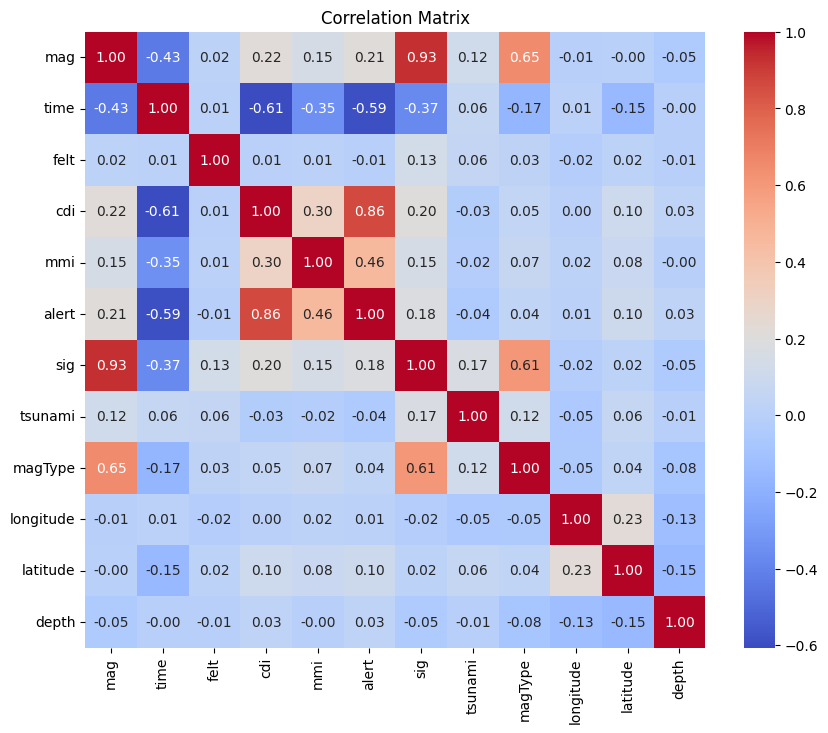

In [10]:
import seaborn as sns

import matplotlib.pyplot as plt

corr_df = dataFrame.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=corr_df.columns, yticklabels=corr_df.columns)
plt.title("Correlation Matrix")
plt.show()

In [11]:
dataFrame.write_csv("dataset.csv")
print("Dataset saved to earthquakes_cleaned.csv")

Dataset saved to earthquakes_cleaned.csv
